In [86]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim

from tqdm import tnrange, tqdm_notebook

import os
from PIL import Image, ImageOps
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from tqdm import tqdm
import h5py
import torch.utils.data as data
from color_utils import (torch_softmax2image,  lab2pil, ab2bin, 
    bin2ab, idx_to_lab, ColorLoss, pil2lab)
from dataset import  hd52numpy, hd52numpy,ColorizeHD5Dataset, img2hdf5, CategoricalColorizeDataSet
from model import ColorizeClassifier
import pretrainedmodels
import wandb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
model = pretrainedmodels.resnext101_64x4d(pretrained=None)

In [88]:
nn.Sequential(*list(model.features.children())[0:5])( torch.randn(1, 1, 256, 256) ).shape

torch.Size([1, 256, 64, 64])

In [89]:
model.features[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [118]:
class ResNextColorizeClassifier(nn.Module):
    '''This produce the nicest looking images'''
    def __init__(self, feature_cascade=(512, 256, 64, 32), classes=262, training=None):
        super(ResNextColorizeClassifier, self).__init__()
        fc = feature_cascade
        self.upsample = nn.Upsample(scale_factor=2)
        fe = (1024, 512, 256, 64)
        
        resnet = pretrainedmodels.resnext101_64x4d(pretrained=None)
        resnet.features[0].weight = nn.Parameter(resnet.features[0].weight.sum(dim=1).unsqueeze(1).data)
        res_children = list(resnet.features.children())
        
        self.ft1 = nn.Sequential(*res_children[0:3]) #64 filters,
        self.ft2 = nn.Sequential(*res_children[3:5]) # 256 filters
        self.ft3 = res_children[5] # 512 filters
        self.ft4 = res_children[6]# 1024 filters
        
        self.bn4 = nn.BatchNorm2d(fe[0])
        self.conv4 = nn.Conv2d(fe[0], fc[0], kernel_size=3, stride=1, padding=1)
        
        sum3 = fc[0] + fe[1]
        self.bn3 = nn.BatchNorm2d(sum3)
        self.conv3 = nn.Conv2d(sum3, fc[1], kernel_size=3, stride=1, padding=1)
        
        sum2 = fc[1] + fe[2] 
        self.bn2 = nn.BatchNorm2d(sum2)
        self.conv2 = nn.Conv2d(sum2, fc[2], kernel_size=3, stride=1, padding=1)
        
        sum1 = fc[2] + fe[3]
        self.bn1 = nn.BatchNorm2d(sum1)
        self.conv1 = nn.Conv2d(sum1, fc[3], kernel_size=3, stride=1, padding=1)
        
        self.bn0 = nn.BatchNorm2d(fc[3])
        self.conv0 = nn.Conv2d(fc[3], classes, kernel_size=3, stride=1, padding=1)
        
    def freeze_ft(self):
        for ft in (self.ft1, self.ft2, self.ft3, self.ft4):
            for param in ft.parameters():
                param.requires_grad = False
                
    def unfreeze_ft(self):
        for ft in (self.ft1, self.ft2, self.ft3, self.ft4):
            for param in ft.parameters():
                param.requires_grad = True
    
    
    def parameters(self, recurse=True):
        for p in super(ResNextColorizeClassifier, self).parameters():
            if p.requires_grad:
                yield p
    
        
    def forward(self, x):
        x1 = self.ft1(x)
        x2 = self.ft2(x1)
        x3 = self.ft3(x2)
        x4 = self.ft4(x3)
        
        x = self.bn4(x4)
        x = self.conv4(x)
        x = F.relu(x)
        
        x = self.upsample(x)
        x = torch.cat((x, x3), dim=1)
        
        x = self.bn3(x)
        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.upsample(x)
        x = torch.cat((x, x2), dim=1)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.upsample(x)
        x = torch.cat((x, x1), dim=1)
        
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        
        
        x = self.upsample(x)
        x = self.bn0(x)
        x = self.conv0(x)
        return x

In [110]:
model = ResNextColorizeClassifier(training=True)
model(torch.randn(1,1,256,256)).shape

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

## Actual Dataset with augmentation

In [82]:
#train_dir = "/home/ec2-user/data/train/imagenet"
train_dir = "/home/ec2-user/data/train/lukas"
ds_train = CategoricalColorizeDataSet(train_dir,  transform=transforms.Compose([
                            transforms.RandomRotation(15, expand=False),
                            transforms.RandomResizedCrop(256),
                            transforms.RandomHorizontalFlip(),
                           ]))
train_loader = data.DataLoader(ds_train,batch_size=16, shuffle=True, num_workers=8)
ds_test = CategoricalColorizeDataSet('/home/ec2-user/data/test/lukas',  transform=transforms.Compose([
                            transforms.Resize(299),
                            transforms.CenterCrop(256),
                           ]))
test_loader = data.DataLoader(ds_test,batch_size=16, shuffle=False)

## Colorization Classifier 

In [83]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        soft_output = y_soft_encode[labels].permute(0,3,1,2)
        loss += criterion(a_out, soft_output).item() * labels.shape[0]
        num += labels.shape[0]
    print(f"Validation Loss: {loss/num}")
    return loss/num

def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, t_loss = [], []
    for e in range(epochs):
        print(f"epoch: {e}")
        running_loss = 0.0
        running_num = 1e-8
        if lrs is not None: lrs.step()
        pbar = tqdm_notebook(train_loader)
            
        for inputs, labels in pbar:
            pbar.set_description(f"loss: {running_loss/running_num}")
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            logits = model(inputs)
            soft_output = y_soft_encode[labels].permute(0,3,1,2)
            loss = criterion(logits, soft_output)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.shape[0]
            running_num += inputs.shape[0]
        tloss = running_loss/running_num
        vloss = get_validation_error(model)
        val_loss.append(vloss)
        t_loss.append(tloss)
    return pd.DataFrame({'loss': val_loss, 't_loss': t_loss})

In [120]:
color_weights = np.load('color_weights.npy')
y_soft_encode = torch.FloatTensor(np.load('soft_encoding.npy')).cuda()
model = ResNextColorizeClassifier()

In [121]:
model.cuda()
model.freeze_ft()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = ColorLoss(torch.FloatTensor(color_weights).cuda())
epochs = 5
loss_hist = train(model, optimizer, criterion, epochs, None)

epoch: 0



Validation Loss: 4.848871813880073
epoch: 1



Validation Loss: 4.7818062040540905
epoch: 2



Validation Loss: 4.820591820610894
epoch: 3



Validation Loss: 4.782718976338704
epoch: 4



Validation Loss: 4.800360785590278


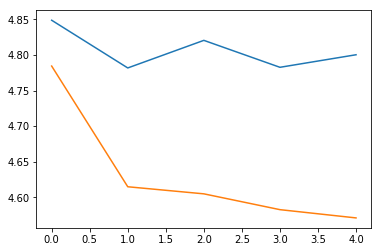

In [122]:
plt.plot(range(epochs), loss_hist['loss'])
plt.plot(range(epochs), loss_hist['t_loss'])

In [123]:
it = iter(test_loader)
xb, yb = next(it)

In [124]:
model.cuda()
with torch.no_grad():
    model.eval()
    yc = model(xb.cuda())

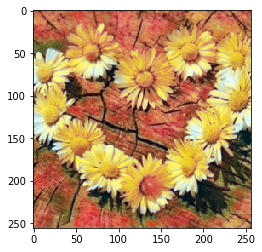

In [125]:
idx = 5
x = (xb.cpu().numpy())[idx,0,:]
y = (yc.cpu().numpy())[idx,:]
plt.imshow(torch_softmax2image(xb, yc, idx, 0.2))

### Develop a way to visualize all the images

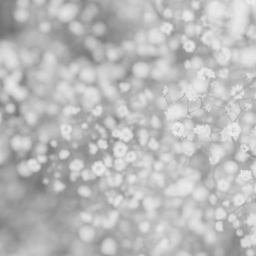

In [100]:
Image.fromarray(np.uint8(np.round((x + 0.5)*255)))

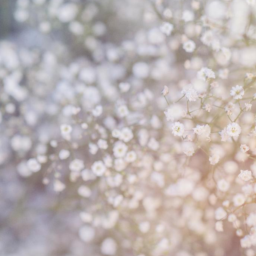

In [29]:
ds_test.get_pil(idx)

### Develop a value interpolation scheme

Take a look at the "Annealing Scheme" proposed in the paper

In [226]:
logits = torch.randn(4)
probs = F.softmax(logits, dim=0)

In [227]:
logits, probs

(tensor([-1.0331,  1.1783,  0.4034,  0.3594]),
 tensor([ 0.0545,  0.4972,  0.2291,  0.2192]))

In [230]:
t = 0.5
z = torch.exp(torch.log(probs)/t) 
(z / z.sum()).numpy().tolist()

[0.008458719588816166,
 0.7048433423042297,
 0.14965175092220306,
 0.1370462328195572]

### Develop the annealing function

In [207]:
yc = y.transpose(1,2,0)

In [238]:
yexp = np.exp(yc)
probs = yexp / yexp.sum(axis=2)[:,:,None]
t = 0.4
z = np.exp(np.log(probs)/t)
z = z / z.sum(axis=2)[:,:,None]

In [239]:
probs_expanded = np.repeat(z[:,:,:,None], 2, 3)
weighted = probs_expanded * idx_to_lab / 255.0
image_ab = np.sum(weighted, axis=2)

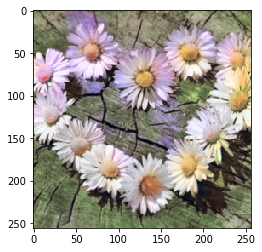

In [240]:
plt.imshow(lab2pil(x[:,:,None], image_ab))

In [167]:
x.shape

(256, 256)